# Лабораторная №1 - Нейронная сеть прямого распространения

## Решаемая задача: распознавание рукописных символов

В данном ноутбуке представлено распознавание рукописных цифр (10 классов) с использованием самописной нейронной сети прямого распространения.

### Данные
Датасет - MNIST. Скачиваем и выполняем предобработку

In [10]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [11]:
import pickle
import gzip
import numpy as np

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


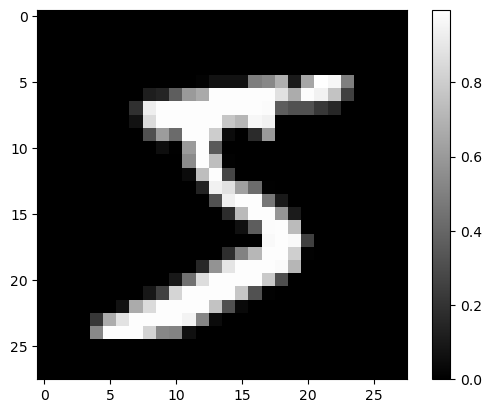

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.grid(False)

Данные уже нормализованы - цвет отдельного пикселя изменяется от 0 до 1

### Реализация сети

In [13]:
import time

def ReLU(x, derivative=False):
    return x * (x > 0) if not derivative else x > 0


def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

class Network:

    def __init__(self, sizes, activation_func=ReLU, output_func=softmax):
        self.sizes = sizes
        self.activation_func = activation_func
        self.output_func = output_func
        # self._norm_init()
        # self._xavier_init()
        self._he_init()

    def _norm_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            self.weights.append(0 + 0.5 * np.random.randn(self.sizes[i-1], self.sizes[i]))
            self.biases.append(np.zeros((1, self.sizes[i])))

    def _xavier_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(6 / (left + right))
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
            
    def _he_init(self):
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(2 / left)
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
       
    def _forward(self, x):
        self.activations = [np.array(x).reshape(1, len(x))]
        
        for i in range(len(self.sizes)-2):
            self.activations.append(self.activation_func(np.dot(self.activations[-1], self.weights[i]) + self.biases[i]))

        self.activations.append(self.output_func(np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]))
        
        return self.activations[-1]

    def _backprop(self, y_valid):
        self.deltaW = []
        self.deltaB = []
        error = self.activations[len(self.sizes)-1] - y_valid
        
        for i in range(len(self.sizes)-2, -1, -1):
            self.deltaW.insert(0, np.dot(self.activations[i].T, error))
            self.deltaB.insert(0, np.sum(error, axis=0, keepdims=True))
            error = np.dot(error, self.weights[i].T) * ReLU(self.activations[i], derivative=True)

    def _update_params(self, learning_rate):
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.deltaW[i]
            self.biases[i] -= learning_rate * self.deltaB[i]
        
    def _onehot(self, y):
        one_hot = np.zeros((1, self.sizes[-1]))
        one_hot[0, y] = 1
        return one_hot
        
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            for x, y in zip(x_train, y_train):
                y_onehot = self._onehot(y)
                self._forward(x)
                self._backprop(y_onehot)
                self._update_params(learning_rate)
                self._forward(x)
                output = self.activations[-1]
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            print(f"====================================\n"
                  f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
        print(f'Total time: {time.time() - start:.2f}')
        
        return time_data, loss_data, acc_data
    
    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        self._forward(x)
        return np.argmax(self.activations[-1])

Архитектура:
* входной слой 784 нейрона (не совсем нейроны) - такова размерность данных
* 1-й скрытый слой 128 нейронов
* 2-й скрытый слой 64 нейрона
* выходной слой 10 нейронов - количество классов

In [14]:
input_ = x_train.shape[1]  # размерность входных данных
hidden1 = 128
hidden2 = 64
output = len(np.unique(y_train))  # количество классов
model = Network([input_, hidden1, hidden2, output])

In [15]:
time_data, loss_data, acc_data = model.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], 10, 0.01)

Epoch 1/10
Loss: 0.0605
Accuracy: 95.34%
Epoch 2/10
Loss: 0.0135
Accuracy: 96.04%
Epoch 3/10
Loss: 0.0082
Accuracy: 96.42%
Epoch 4/10
Loss: 0.0053
Accuracy: 96.94%
Epoch 5/10
Loss: 0.0038
Accuracy: 96.96%
Epoch 6/10
Loss: 0.0028
Accuracy: 97.10%
Epoch 7/10
Loss: 0.0021
Accuracy: 97.28%
Epoch 8/10
Loss: 0.0019
Accuracy: 97.10%
Epoch 9/10
Loss: 0.0015
Accuracy: 97.00%
Epoch 10/10
Loss: 0.0012
Accuracy: 97.10%
Total time: 80.17


Среднее время выполнения одной итерации: 7.86


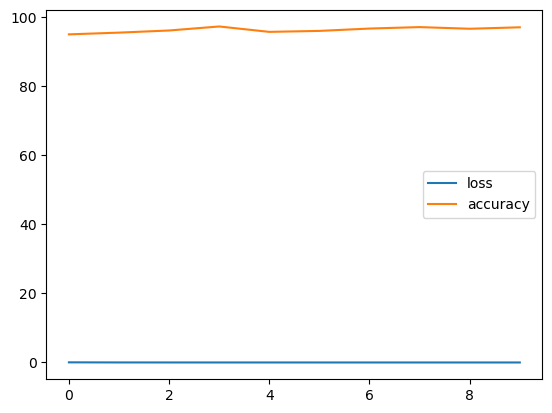

In [72]:
print(f'Среднее время выполнения одной итерации: {np.mean(time_data):.2f}')
x_i = [i for i in range(10)]
plt.plot(x_i, loss_data, label='loss')
plt.plot(x_i, acc_data, label='accuracy')
plt.legend()
plt.show()

In [76]:
print(f'Validation...')
x_valid = x_test[len(x_test)//2:]
y_valid = y_test[len(y_test)//2:]
valid_accuracy = model.test(x_test[len(x_test)//2:], y_test[len(y_test)//2:])
print(f'Accuracy: {valid_accuracy:.2f}%')

Validation...
Accuracy: 97.30%


In [77]:
def visualize(images, labels, real, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Prediction: {labels[i]}\nActual: {real[i]}')
        axes[i].axis('off')
    plt.show()

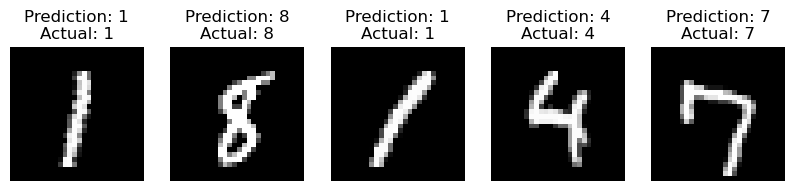

In [78]:
predictions = []
count = 5
x = []
y = []
for i in range(count):
    i_x = np.random.randint(0, x_valid.shape[0])
    x.append(x_valid[i_x])
    y.append(y_valid[i_x])
    predictions.append(model.predict(x_valid[i_x]))
visualize(x, predictions, y, count)